In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s, i in stoi.items()}

In [5]:
vocab_size = len(itos)

In [62]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        # print(x)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [71]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps =eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim=0
            elif x.ndim == 3:
                dim =(0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [10]:
class Embedding:
    def __init__(self,num_embeddings, embeeding_dim):
        self.weight = torch.rand((num_embeddings,embeeding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

In [64]:
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
    def __call__(self, x):
        B ,T ,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

In [52]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [54]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [39]:
model.layers[1].out.shape

torch.Size([4, 80])

In [40]:
model.layers[2].out.shape

torch.Size([4, 200])

In [73]:
n_embd = 10
n_hidden = 68
g = torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size, n_embd), generator=g)
model  = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *=0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [74]:
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb,Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  6],
        [ 0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  1,  4,  4,  9,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [75]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0] , (batch_size,))
    Xb ,Yb = Xtr[ix],Ytr[ix]

    # emb = C[Xb]
    # x = emb.view(emb.shape[0],-1)
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i <150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3034
  10000/ 200000: 2.3412
  20000/ 200000: 2.4580
  30000/ 200000: 1.9179
  40000/ 200000: 2.2706
  50000/ 200000: 2.0972
  60000/ 200000: 2.2721
  70000/ 200000: 2.0643
  80000/ 200000: 2.1990
  90000/ 200000: 1.8643
 100000/ 200000: 2.1508
 110000/ 200000: 2.0771
 120000/ 200000: 1.7127
 130000/ 200000: 2.3165
 140000/ 200000: 2.2123
 150000/ 200000: 2.0517
 160000/ 200000: 1.7372
 170000/ 200000: 2.1593
 180000/ 200000: 1.8279
 190000/ 200000: 1.9619


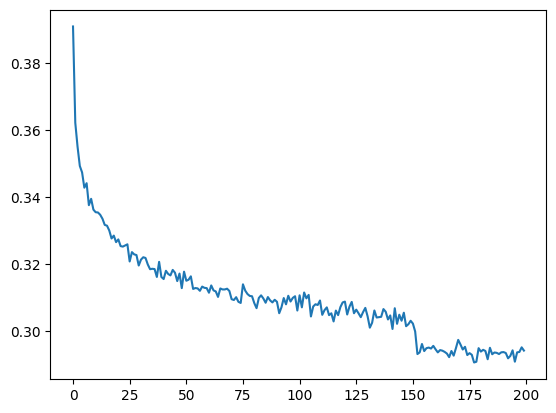

In [72]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [29]:
for layer in model.layers:
    layer.training = False

In [30]:
Xtr,Ytr

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         ...,
         [15, 12,  4],
         [12,  4,  1],
         [ 4,  1, 14]]),
 tensor([25, 21,  8,  ...,  1, 14,  0]))

In [31]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.281137228012085
val 3.2824082374572754


In [32]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

ybsjkjk.
lotbmqwtnaicbwlzomjjhju.
cqnoojgmheaxrtowwzwkycajy.
jczyicuzshqmiaewiczfxamjw.
npmyrhekmazo.
uqtdpazjxlzsxjwfnoeocqvzishqeuvbqsaiuaxm.
kpbevahgtqyxsva.
mmndrcuqymkjaanph.
jhtnjryqwtuquqasmid.
dbk.
kbdlcplrpwpzc.
yvtooinaxudupqxvpzu.
zzhuhhdduo.
omnnmvgtryxctwb.
rr.
kolcidmlatertaklxxzgenzlyezharldjwgzzjjjnsyeatdalmmiphetdepjwlnyxmhiueczgkodnjyjcwzxxewjtrv.
pyagutowiotj.
bjzmqirjxgwbesshmt.
xlaxpvxb.
xxgrmlgpmtt.
